# 天元 MegEngine 基本概念入门

<table class="mge-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="#"><img src="../../assets/logo/megengine-32.png" />在天元官网查看</a>
  </td>
  <td>
    <a target="_blank" href="#"><img src="../../assets/logo/megvii-32.svg" />在 MegStudio 中运行</a>
  </td>
  <td>
    <a target="_blank" href="#"><img src="../../assets/logo/github-32.svg" />在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="#"><img src="../../assets/logo/download-32.svg" />下载当前教程文件</a>
  </td>
</table>

我们为第一次接触天元 MegEngine 框架的用户提供了此系列教程，通过本部分的学习，你将会：

- 对天元 MegEngine 框架中的 `Tensor`, `Operator`, `GradManager` 等基本概念有一定的了解；
- 对深度学习中的前向传播、反向传播和参数更新的具体过程有更加清晰的认识；
- 通过写代码训练一个线性回归模型，对上面提到的这些概念进行具体的实践，加深理解。

请先运行下面的代码，检验你的环境中是否已经安装好 MegEngine（[访问官网安装教程](https://megengine.org.cn/install)）：

In [1]:
import megengine

print(megengine.__version__)

1.1.0


接下来，我们将学习框架中一些基本模块的使用，先从最基础的张量（Tensor）和算子（Operator）开始吧～

## 张量（Tensor）

真实世界中的很多非结构化的数据，如文字、图片、音频、视频等，都可以表达成更容易被计算机理解的形式。

MegEngine 使用张量（Tensor）来表示数据。类似于 [NumPy](https://numpy.org/) 中的 ndarray，张量可以是标量、向量、矩阵或者多维数组。

在 MegEngine 中得到一个 Tensor 的方式有很多： 
- 我们可以通过 `megengine.functional.tensor` 的 `arange()`, `ones()` 等方法来生成 Tensor，`functional` 模块我们会在后面介绍；
- 也可以通过 `Tensor()` 或 `tensor()` 方法，传入 Python List 或者 ndarray 来创建一个 Tensor

In [2]:
import numpy as np
import megengine as mge # 我们习惯将 MegEngine 缩写为 mge
import megengine.functional as F # 我们习惯将 functional 缩写为 F

# 1. 生成 Python List，然后转化为 MegEngine Tensor
py_list = range(5)
print(mge.tensor(py_list))

# 2. 生成 Numpy ndarray，然后转化为 MegEngine Tensor
np_ndarray = np.arange(5).astype("float32")
print(mge.tensor(np_ndarray))

# 3. 使用 functional 模块直接生成 MegEngine Tensor
mge_tensor = F.arange(5)
print(mge_tensor)

Tensor([0 1 2 3 4], dtype=int32, device=xpux:0)
Tensor([0. 1. 2. 3. 4.], device=xpux:0)
Tensor([0. 1. 2. 3. 4.], device=xpux:0)


通过 `dtype` 属性我们可以获取 Tensor 的数据类型，默认 `float32` 类型不进行显示；
- 为了方便，统一使用 NumPy 的 `dtype` 表示；
- MegEngine Tensor 目前不支持 `float64` 类型；
- 使用 `type()` 可以获取实际的类型，用来区分 ndarray 和 Tensor

In [3]:
print(mge_tensor.dtype)
print(type(mge_tensor))

<class 'numpy.float32'>
<class 'megengine.tensor.Tensor'>


通过 `astype()` 方法我们可以拷贝创建一个指定数据类型的新 Tensor ，原 Tensor 不变：

In [4]:
new_tensor = mge_tensor.astype("float16")
print(new_tensor)

Tensor([0. 1. 2. 3. 4.], dtype=float16, device=xpux:0)


通过 `device` 属性，我们可以获取 Tensor 当前所在的设备：
- 一般地，如果在创建 Tensor 时不指定 `device`，其 `device` 属性默认为 `xpux`，表示当前任意一个可用的设备；
- 在 GPU 和 CPU 同时存在时，**MegEngine 将自动使用 GPU 作为默认设备进行训练**，查看 `device` 文档了解更多细节。

通过 Tensor 自带的 `numpy()` 方法，可以拷贝 Tensor 并转化对应的 ndarray，原 Tensor 不变：:

In [5]:
print(type(mge_tensor.numpy()))

<class 'numpy.ndarray'>


如果要取得标量的值，可以先转换成 NumPy 的 ndarray 后，再使用 `item()` 方法：

In [6]:
print(type(mge_tensor[0]))
print(type(mge_tensor[0].numpy()))
print(type(mge_tensor[0].numpy().item()))

<class 'megengine.tensor.Tensor'>
<class 'numpy.ndarray'>
<class 'float'>


可以发现，不同类型之间的转化比较灵活，但需要注意：
- MegEngine Tensor 没有 `mge.numpy(mge_tensor)` 这种用法；
- `tensor` 是 `Tensor` 的一个别名（Alias），也可以尝试直接这样导入：

In [7]:
from megengine import tensor
from megengine import Tensor

print(tensor([1, 2, 3]))      # 实际上我们更希望使用 float32 类型的 Tensor
print(Tensor([1., 2., 3.]))   # 因此我们会习惯性地加上一个点表示这是浮点数

Tensor([1 2 3], dtype=int32, device=xpux:0)
Tensor([1. 2. 3.], device=xpux:0)


通过 `shape` 属性，我们可以获取 Tensor 的形状：

In [8]:
matrix_tensor = mge.tensor([[1., 2., 3.], 
                            [4., 5., 6.]])
print(matrix_tensor.shape)

(2, 3)


通过 `size` 属性，我们可以获取 Tensor 中元素的个数：

In [9]:
print(matrix_tensor.size)   # 2 * 3 = 6

6


## 算子（Operator）

MegEngine 中通过算子 (Operator） 来表示运算。MegEngine 中的算子支持基于 Tensor 的常见数学运算和操作。

比如 Tensor 的元素间（Element-wise）加法、减法和乘法：

In [10]:
A = mge.tensor([[2., 4., 2.], 
                [2., 4., 2.]])
B = mge.tensor([[1., 2., 1.], 
                [1., 2., 1.]])

print(A + B)
print(A - B)
print(A * B)
print(A / B)

Tensor([[3. 6. 3.]
 [3. 6. 3.]], device=xpux:0)
Tensor([[1. 2. 1.]
 [1. 2. 1.]], device=xpux:0)
Tensor([[2. 8. 2.]
 [2. 8. 2.]], device=xpux:0)
Tensor([[2. 2. 2.]
 [2. 2. 2.]], device=xpux:0)


你也可以使用 MegEngine 中的 `functional` 模块中的各种方法来完成对应计算：

In [11]:
import megengine.functional as F 

print(F.add(A, B))
print(F.sub(A, B))
print(F.mul(A, B))
print(F.div(A, B))

Tensor([[3. 6. 3.]
 [3. 6. 3.]], device=xpux:0)
Tensor([[1. 2. 1.]
 [1. 2. 1.]], device=xpux:0)
Tensor([[2. 8. 2.]
 [2. 8. 2.]], device=xpux:0)
Tensor([[2. 2. 2.]
 [2. 2. 2.]], device=xpux:0)


Tensor 支持 Python 中常见的切片（Slicing）操作：

In [12]:
A = mge.tensor([[1., 2., 3.], 
                [4., 5., 6.]])

print(A[1, :2])

Tensor([4. 5.], device=xpux:0)


使用 `reshape()` 方法，可以得到修改形状后的 Tensor:

In [13]:
A = mge.tensor([[1., 2., 3.], 
                [4., 5., 6.]])

print(A.shape)
A = A.reshape(3, 2)
print(A.shape)

(2, 3)
(3, 2)


另外， `reshape()` 方法的参数允许存在单个维度的缺省值，用 -1 表示。此时，`reshape()` 会自动推理该维度的值：

In [14]:
A = mge.tensor(np.random.random((2, 3, 4, 5)))

print(A.shape)
A = A.reshape(2, -1, 5)
print(A.shape)

(2, 3, 4, 5)
(2, 12, 5)


在 `functional` 模块中提供了更多的算子，比如 Tensor 的矩阵乘可以使用 `matmul()` 方法：

In [15]:
x = mge.tensor([[1., 3., 5.],
                [2., 4., 6.]])
w = mge.tensor([[1., 2.],
                [3., 4.],
                [5., 6.]])

p = F.matmul(x, w)
print(p)

Tensor([[35. 44.]
 [44. 56.]], device=xpux:0)


我们可以使用 NumPy 的矩阵乘来验证一下这个结果：

In [16]:
import numpy as np

x = np.array([[1., 3., 5.],
              [2., 4., 6.]])
w = np.array([[1., 2.],
              [3., 4.],
              [5., 6.]])

p = np.matmul(x, w)
print(p)

[[35. 44.]
 [44. 56.]]


更多算子可以参考 `functional` 模块的文档部分。

现在你可以适当休息一下，脑海中回想一下张量（Tensor）和算子（Operator）的概念，然后继续阅读教程后面的部分。

## 计算图（Computing Graph）

MegEngine 是基于计算图（Computing Graph）的深度神经网络学习框架，下面通过一个简单的数学表达式 $y=(x * w)+b$ 来介绍计算图的基本概念，如下图所示：

![Computing Graph](../../assets/images/computing_graph.png)

计算之间的各种流程依赖关系可以构成一张计算图，从中可以看到，计算图中存在：
- 数据节点（图中的实心圈）：如输入数据 $x$、**参数** $w$ 和 $b$，运算得到的中间数据 $p$，以及最终的运算输出 $y$；
- 计算节点（图中的空心圈）：图中 $*$ 和 $+$ 分别表示计算节点 **乘法** 和 **加法**，是施加在数据节点上的运算；
- 边（图中的箭头）：表示数据的流向，体现了数据节点和计算节点之间的依赖关系

**在 MegEngine 中，用张量（Tensor）表示计算图中的数据节点，用算子（Operator）实现数据节点之间的运算。**

**在深度学习领域，任何复杂的深度神经网络模型本质上都可以用一个计算图表示出来。**

神经网络模型的训练其实就是在重复以下过程：
- **前向传播**：计算由计算图表示的数学表达式的值的过程。在上图中则是：
  - 输入 $x$ 和参数 $w$ 首先经过乘法运算得到中间结果 $p$，
  - 接着 $p$ 和参数 $b$ 经过加法运算，得到右侧最终的输出 $y$，这就是一个完整的前向传播过程。
- **反向传播**：根据计算图的输出，通过链式求导法则，对所有的参数求梯度。在上图中，即计算 $\frac{\partial y}{\partial w}$ 和 $\frac{\partial y}{\partial b}$.
- **参数更新**：得到梯度后，需要使用梯度下降法（Gradient Descent）对参数做更新，从而达到模型优化的效果。在上图中，即对 $w$ 和 $b$ 做更新。

模型训练完成后便可用于测试（或者说推理），此时我们不需要再对模型本身做任何更改，只需要将数据经过前向传播得到对应的输出即可。

### 链式法则计算梯度

例如，为了得到上图中 $y$ 关于参数 $w$ 的梯度，反向传播的过程如下图所示：

![Backpropagation](../../assets/images/back_prop.png)

- 首先 $y = p + b$，因此 $\frac{\partial y}{\partial p} = 1$ 
- 接着，反向追溯，$p = x * w$ ，因此，$\frac{\partial p}{\partial w}=x $
- 根据链式求导法则，$\frac{\partial y}{\partial w}=\frac{\partial y}{\partial p} * \frac{\partial p}{\partial w} = 1 * x $
- 因此最终 $y$ 关于参数 $w$ 的梯度为 $x$.

## 求导器（Grade Manager）

推导梯度是件枯燥的事情，尤其是当模型的前向传播计算输出的过程变得相对复杂时，根据链式法则计算梯度会变得异常枯燥无味。

自动求导是深度学习框架对使用者而言最有用的特性之一，它自动地完成了反向传播过程中根据链式法则去推导参数梯度的过程。

MegEngine 的 `autodiff` 模块为计算图中的张量提供了自动求导功能，继续以上图的例子进行说明：

假设图中的 $x$ 是 shape 为 $(1, 3)$ 的张量， $w$ 是 shape 为 $(3, 1)$ 的张量， $b$ 是一个标量。利用 MegEngine 计算 $y = w * x + b$ 的过程如下：

In [17]:
from megengine.autodiff import GradManager

x = mge.tensor([1., 3., 5.]).reshape(1, 3)
w = mge.tensor([2., 4., 6.]).reshape(3, 1)
b = mge.tensor(-1.)

gm = GradManager().attach([w, b])   # 新建一个求导器，绑定需要求导的变量，实例通常习惯写成 gm
with gm:                            # 开始记录计算图
    p = F.matmul(x, w)
    y = p + b                       
    gm.backward(y)                  # 计算 y 关于参数的导数，过程中不断地使用链式法则

print(w.grad)                       # 得到结果为 x
print(b.grad)                       # 得到结果为 1

Tensor([[1.]
 [3.]
 [5.]], device=xpux:0)
Tensor([1.], device=xpux:0)


可以看到，求出的梯度本身也是 Tensor，`GradManager` 负责管理和计算梯度（在默认情况下，Tensor 是不需要计算梯度的）。

我们可以使用 `attach()` 来绑定需要计算梯度的变量（绑定后可使用 `detach()` 将其取消绑定），使用 `backward()` 进行梯度的计算。

上面 `with` 代码段中的前向运算都会被求导器记录，有关求导器的原理，可以查看 `GradManager` 文档了解细节。

## 优化器（Optimizer）

你应该注意到了，我们使用参数（Parameter）来称呼张量（Tensor）$w$ 和 $b$, 因为与输入 $x$ 不同，计算图中的 $w$ 和 $b$ 是需要进行更新/优化的变量。

MegEngine 中使用 `Parameter` 来表示参数（注意没有小写形式），Parameter 是 Tensor 的子类，其对象（即网络参数）可以被优化器更新。

显然，GradManager 支持对于 Parameter 的梯度计算：

In [18]:
x = mge.tensor([1., 3., 5.]).reshape(1, 3)
w = mge.Parameter([2., 4., 6.]).reshape(3, 1)
b = mge.Parameter(-1.)

print(type(w))
print(type(b))

gm = GradManager().attach([w, b])   # 这次 attach() 传入的是 Parameter 而不是 Tensor
with gm:                            
    p = F.matmul(x, w)
    y = p + b                       
    gm.backward(y)                  
    
print(type(w.grad))                 # 计算得到的梯度依然是 Tensor

<class 'megengine.tensor.Parameter'>
<class 'megengine.tensor.Parameter'>
<class 'megengine.tensor.Tensor'>


前向传播和反向传播的过程完成后，我们得到了参数对应需要更新的梯度，如 `w` 相对于输出 $y$ 的梯度 `w.grad`. 

根据梯度下降的思想，参数 $w$ 的更新规则为：`w = w - lr * w.grad`, 其中 `lr` 是学习率（Learning Rate），控制参数更新速度。

P.S: 类似学习率这种，训练前人为进行设定的，而非由模型学得的参数，通常被称为超参数（Hyperparameter）。

MegEngine 的 `Optimizer` 模块提供了基于各种常见优化策略的优化器，如 Adam 和 SGD 等。

它们都继承自 Optimizer 基类，主要包含参数梯度的清空 `clear_grad()` 和参数更新 `step()` 这两个方法：

In [19]:
import megengine.optimizer as optim      # 我们习惯将 optimizer 缩写为 optim

optimizer = optim.SGD([w, b], lr=0.01)   # 实例化随机梯度下降（SGD）优化器，传入 Parameter w 和 b
optimizer.step()                         # 更新参数值 w = w - lr * w.grad
optimizer.clear_grad()                   # 将参数的梯度清空，节省内存，以便下一次计算，w.grad 变为 None

print(w, w.grad)

Tensor([[1.99]
 [3.97]
 [5.95]], device=xpux:0) None


**提示：**多次实践表明，用户经常忘记在更新参数后做梯度清空操作，因此推荐使用这样的写法：`optimizer.step().clear_grad()`

我们使用 Numpy 来手动模拟一次参数 `w` 的更新过程：

In [20]:
w = np.array([2., 4., 6.])
dw = np.array([1., 3., 5.])              # 前面我们已经计算出了 w.grad = x, 这里用 dw 表示
lr = 0.01

w = w - lr * dw
print(w)                                 # 和 optimizer.step() 更新后得到的 w 应该一致

[1.99 3.97 5.95]


这样我们便成功地进行了一次参数更新，在实际训练模型时，参数的更新会迭代进行很多次，迭代次数 `epochs` 也是一种超参数，需要人为设定。

## 损失函数（Loss Function）

现在我们明白了，深度神经网络模型的优化过程，实际上就是使用梯度下降算法来更新模型中的参数。

但请注意，上面的 $y$ 只是表达式的输出结果，并不是我们需要优化的目标，我们的目标是：模型输出和真实结果尽可能接近。

有了数据之后通过前向传播可以得到模型的输出，此时我们用 **损失函数（Loss Function）** 来度量模型输出与真实结果之间的差距。

MegEngine 提供了各种常见损失函数，具体可见文档中的 `loss` 部分。

对于 $y = w * x + b$ 这样的线性模型，我们这里使用均方误差损失（Mean Square Loss, MSE）表示模型输出 $y_{pred}$ 和实际值 $y_{real}$ 的差距：

$$
\ell(y_{pred}, y_{real})= \frac{1}{n }\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}
$$

注：在上面的公式中 $\left(y_{i}-\hat{y}_{i}\right)^{2}$ 计算的是单个样本 $x_{i}$ 输入模型后得到的输出 $y_{i}$ 和实际值 $\hat{y}_{i}$ 的差异，数据集中有 $n$ 个样本。

In [21]:
import megengine.functional as F

pred = np.array([3, 3, 3, 3]).astype(np.float32)
real = np.array([2, 8, 6, 1]).astype(np.float32)

loss = np.mean((pred - real) ** 2)       # 根据公式定义计算
print(loss)

loss = F.nn.square_loss(pred, real)      # MegEngine 中的实现
print(loss)

9.75
9.75


选定损失函数作为优化目标后，我们可通过梯度下降不断地更新参数 $w$ 和 $b$, 从而减少模型输出和实际值的差异。

## 练习：线性回归

接下来，我们用一个非常简单的例子，帮助你将前面提到的概念给联系起来。

假设有人提供给你一些包含数据 `data` 和标签 `label` 的样本集合 $S$ 用于训练模型，希望将来给出输入 $x$, 模型能对输出 $y$ 进行较好地预测：

$$
\begin{aligned}
data &= [x_1, x_2, \ldots , x_n] \\
label &= [y_1, y_2, \ldots , y_n] \\
S &= \{(x_1, y_1), (x_2, y_2), \ldots (x_n, y_n)\}
\end{aligned}
$$

请运行下面的代码以随机生成包含 `data` 和 `label` 的样本:

The real w: 5, b: -2


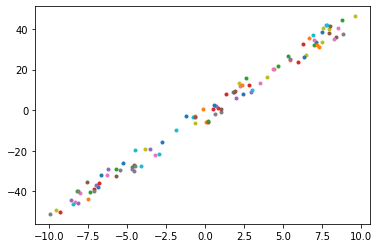

In [22]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

def generate_random_examples(n=100, noise=5):

    w = np.random.randint(5, 10)
    b = np.random.randint(-10, 10)
    print("The real w: {}, b: {}".format(w, b))
    
    # 初始化 data 和 label
    data = np.zeros((n,))
    label = np.zeros((n,))
    
    # 生成 n 个随机样本数据，并添加一定的噪声干扰
    for i in range(n):
        data[i] = np.random.uniform(-10, 10)
        label[i] = w * data[i] + b + np.random.uniform(-noise, noise)
        plt.scatter(data[i], label[i], marker=".")  # 将样本点绘制在坐标图上
    
    # 展示样本数据的分布
    plt.plot()
    plt.show()
    return data, label

original_data, original_label = generate_random_examples()

通过可视化观察样本的分布规律，不难发现，我们可以:
1. 尝试拟合 $y = w * x + b$ 这样一个线性模型（均为标量）；
2. 选择使用均方误差损失作为优化目标；
3. 通过梯度下降法来更新参数 $w$ 和 $b$.

### Numpy 实现

对于这种非常简单的模型，完全可以使用 Numpy 进行算法实现，我们借此了解一下整个模型训练的流程：

epoch = 0, w = 3.325, b = -0.019, loss = 846.077


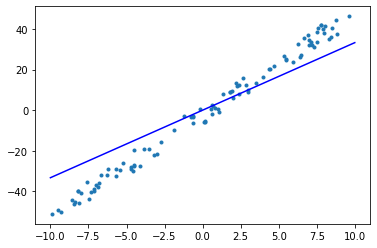

epoch = 1, w = 4.445, b = -0.053, loss = 107.139


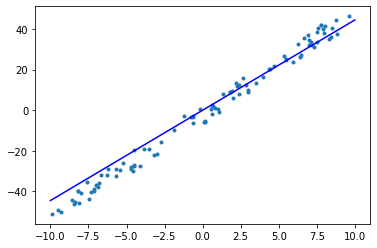

epoch = 2, w = 4.822, b = -0.091, loss = 23.131


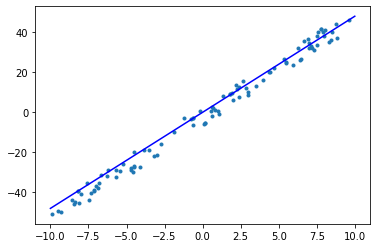

epoch = 3, w = 4.950, b = -0.130, loss = 13.452


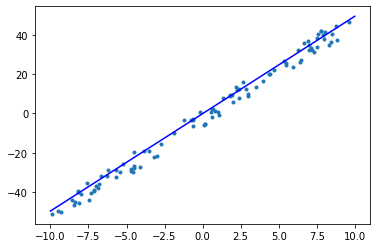

epoch = 4, w = 4.993, b = -0.169, loss = 12.214


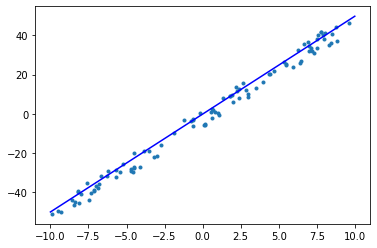

In [23]:
# 设置超参数
epochs = 5
lr = 0.01

# 获取数据
data = original_data
label = original_label
n = len(data)

# 参数初始化
w = 0
b = 0

# 定义模型
def linear_model(x):
    return w * x + b

# 模型训练
for epoch in range(epochs):
    
    # 初始化单个 epoch 训练得到的损失
    loss = 0
    
    # 梯度初始化，等同于 Optimizer 中的 clear_grad()
    sum_grad_w = 0
    sum_grad_b = 0
    
    # 为了方便理解，这里没有使用 “向量化实现”，而是使用了 for 循环写法
    for i in range(n):
        
        # 前向传播，主要计算预测值 pred 以及损失值 loss
        pred = linear_model(data[i])      # 通常 pred 为将 data 代入 “模型” 得到的输出，即 model(data)
        loss += (pred - label[i]) ** 2    # 等同于对每个样本使用 F.nn.loss(pred, label) 计算后求和
        
        # 反向传播，根据均方误差损失计算参数的梯度，这里不解释推导过程，等同于 gm.backward()
        sum_grad_w += 2 * (pred - label[i]) * data[i]
        sum_grad_b += 2 * (pred - label[i])
    
    # 计算平均损失，因为对于不同的输入，求得的损失都会不同，所以通常求和后取平均
    loss = loss / n
    
    # 计算平均梯度，因为对于不同的输入，求得的梯度都会不同，所以通常求和后取平均
    grad_w = sum_grad_w / n
    grad_b = sum_grad_b / n
    
    # 更新参数，等同于 Optimizer 中的 step()
    w = w - lr * grad_w
    b = b - lr * grad_b
    
    # 查看参数和损失
    print("epoch = {}, w = {:.3f}, b = {:.3f}, loss = {:.3f}".format(epoch, w, b, loss))
    
    # 绘图查看拟合情况
    x = np.array([-10, 10])
    y = w * x + b
    plt.scatter(data, label, marker=".")
    plt.plot(x, y, "-b")
    plt.show()

可以看到，在 5 个 epochs 的迭代训练中，已经得到了一个拟合状况不错的线性模型。

### MegEngine 实现

上面的流程，完全可以使用 MegEngine 来实现（有兴趣的读者可以参照上面的注释，先尝试自己实现）：

In [24]:
import megengine as mge
import megengine.functional as F
from megengine.autodiff import GradManager
import megengine.optimizer as optim

# 设置超参数
epochs = 5
lr = 0.01

# 获取数据
data = mge.tensor(original_data)
label = mge.tensor(original_label)

# 初始化参数
w = mge.Parameter([0.0])
b = mge.Parameter([0.0])

# 定义模型
def linear_model(x):
    return F.mul(w, x) + b

# 定义求导器和优化器
gm = GradManager().attach([w, b])
optimizer = optim.SGD([w, b], lr=lr)

# 模型训练
for epoch in range(epochs):
    with gm:
        pred = linear_model(data)
        loss = F.nn.square_loss(pred, label)
        gm.backward(loss)
    optimizer.step().clear_grad()
    
    print("epoch = {}, w = {:.3f}, b = {:.3f}, loss = {:.3f}"
          .format(epoch, w.numpy().item(), b.numpy().item(), loss.numpy().item()))

epoch = 0, w = 3.325, b = -0.019, loss = 846.077
epoch = 1, w = 4.445, b = -0.053, loss = 107.139
epoch = 2, w = 4.822, b = -0.091, loss = 23.131
epoch = 3, w = 4.950, b = -0.130, loss = 13.452
epoch = 4, w = 4.993, b = -0.169, loss = 12.214


你应该会得到相同的 `w`, `b` 以及 `loss` 值，下面直线的拟合程度也应该和 Numpy 实现一致：

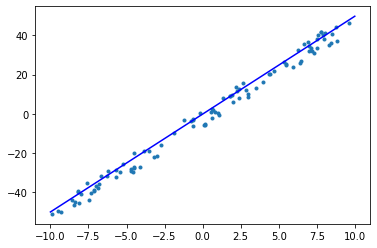

In [25]:
# 绘图查看拟合情况
x = np.array([-10, 10])
y = w.numpy() * x + b.numpy()
plt.scatter(data, label, marker=".")
plt.plot(x, y, "-b")
plt.show()

## 总结回顾

祝贺你完成了入门教程的学习，现在是时候休息一下，做一个简单的回顾了：

到目前为止，我们已经掌握了天元 MegEngine 框架中的以下概念：
- 计算图（Computing Graph）：MegEngine 是基于计算图的框架，计算图中存在数据节点、计算节点和边
  - 前向传播：输入的数据在计算图中经过计算得到最终输出的过程，我们使用损失 `loss` 表示预测值和实际值的差异
  - 反向传播：根据链式法则，得到计算图中所有参数 w 关于 loss 的梯度 dw ，实现在 `autodiff` 模块，由 `GradManager` 进行管理
  - 参数更新：根据梯度下降算法，更新图中参数，从而达到优化最终 loss 的效果，实现在 `optimzer` 模块
- 张量（Tensor）：MegEngine 中的基础数据结构，用来表示计算图中的数据节点，可以灵活地与 Numpy 数据结构转化
  - 参数（Parameter）：用于和张量做概念上的区分，模型优化的过程实际上就是优化器对参数进行了更新
- 算子（Operator）：基于 Tensor 的各种计算的实现（包括损失函数），实现在 `functional` 模块

我们通过拟合 $y = w * x + b$ 完成了一个最简单的线性回归模型的训练，干得漂亮！

## 问题思考

我们的 MegEngine 打怪升级之旅还没有结束，在前往下一关之前，尝试思考一些问题吧。

关于向量化实现：

- 当你发现 Python 代码运行较慢时，通常可以将数据处理移入 NumPy 并采用向量化（Vectorization）写法，实现最高速度的处理
- 线性模型训练的 NumPy 写法中，单个 `epoch` 训练内出现了 `for` 循环，实际上可以采取向量化的实现（参考 MegEngine 实现的写法）
- 使用向量化的实现，通常计算的效率会更高，因此建议：代码中能够用向量化代替 `for` 循环的地方，就尽可能地使用向量化实现

关于设备：

- 都说 GPU 训练神经网络模型速度会比 CPU 训练快非常多，为什么？
- 我们可以把 Tensor 指定计算设备为 GPU 或 CPU，而原生 NumPy 只支持 CPU 计算，Tensor 转化为 ndarray 的过程是什么样的？
- 训练的速度是否会受到训练设备数量的影响呢？可不可以多个设备一起进行训练？

关于参数与超参数：
- 现在我们接触到了两个超参数 `epochs` 和 `lr`, 调整它们的值是否会对模型的训练产生影响？（不妨自己动手调整试试）
- 我们看上去得到了一条拟合得很不错的曲线，但是得到的 `b` 距离真实的 `b` 还比较遥远，为什么？如何解决这种情况？
- 如何选取合适的超参数，对于超参数的选取是否有一定的规律或者经验可寻？

关于数据集：
- 我们在线性模型中使用的是从 NumPy 代码生成的随机数据，修改数据集的样本数量 `n` 和噪声扰动程度 `noise` 会有什么影响？
- 对于现实中的数据集，如何转换成 MegEngine Tensor 的形式进行使用？
- 这中间需要经过什么样的预处理（Preprocessing）过程，有哪些流程是可以交由框架来完成的？

关于模型：
- 我们学会了定义了非常简单的线性模型 `linear_model`, 更复杂的模型要如何去写？
- 既然任何神经网络模型本质上都可以用计算图来表示，那么神经网络模型的搭建流程是什么样的？

关于最佳实践：
- 在编写代码时，经常会有根据前人经验总结出的最佳实践（Best Practice）作为参考，例如：
  - 参数的更新和梯度的清空可以写在一起 `optimizer.step().clear_grad()`
  - 在导入某些包的时候，通常有约定俗成的缩写如 `import megengine as mge`
- 除此以外，还有什么样的编程习惯和最佳实践值得参考？如何将一份玩具代码整理变成工程化的代码？

答案最终将由你来揭晓，我们鼓励你在实践中不断思考，并启发自己去探索直觉性或理论性的解释。